## *J) Innovation Droupout in the test data as well

### J.1Second model that we have the droup out in the test and train data 

Epoch 1/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 11743.3975 - mae: 81.9073 - val_loss: 3699.1594 - val_mae: 45.8373
Epoch 2/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3894.3809 - mae: 48.5577 - val_loss: 3710.5090 - val_mae: 44.4675
Epoch 3/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3637.1829 - mae: 46.8836 - val_loss: 3985.2808 - val_mae: 46.4330
Epoch 4/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3497.8965 - mae: 46.1714 - val_loss: 4025.3672 - val_mae: 46.3094
Epoch 5/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3273.0300 - mae: 44.5398 - val_loss: 3990.0552 - val_mae: 46.2251
Epoch 6/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3298.7087 - mae: 44.2563 - val_loss: 5150.2578 - val_mae: 53.5321
Epoch 7/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3194.2896 - mae: 43.8807 - val_loss: 4604.9141 - val_mae: 50.1068
Epoch 8/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3186.3486 - mae: 44.0057 - val_loss: 4626.2017 - val_mae:

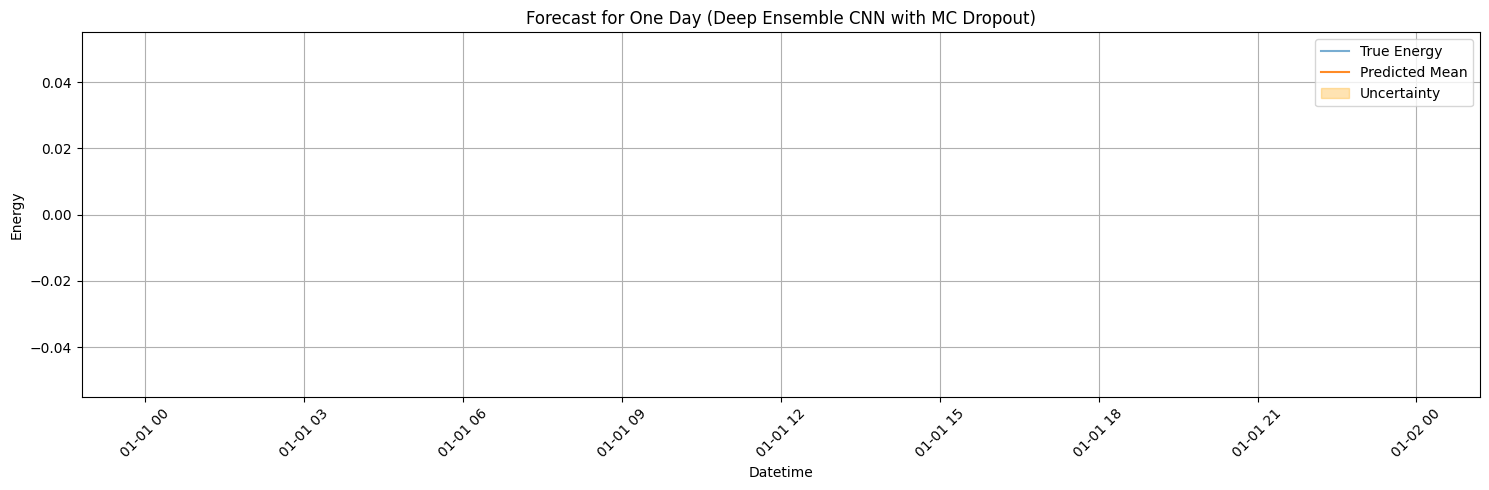

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Parameters ---
window_size = 48
n_ensemble = 5
epochs = 30
features = [
    'air_temperature', 'diffuse_r', 'elspot', 'full_solar',
    'global_r', 'gust_speed', 'relative_humidity', 'sunshine',
    'wind_speed'
]
target = 'energy'

# --- Load datasets ---
df_train = pd.read_excel("X_train_scaled.xlsx")
df_val = pd.read_excel("X_val_scaled.xlsx")
df_test = pd.read_excel("X_test_scaled.xlsx")

# --- Create sliding windows ---
def create_sliding_windows(df, window_size, features, target):
    X, y, timestamps = [], [], []
    feature_array = df[features].values
    target_array = df[target].values
    datetime_array = pd.to_datetime(df['datetime'])

    for i in range(len(df) - window_size):
        X.append(feature_array[i:i + window_size])
        y.append(target_array[i + window_size])
        timestamps.append(datetime_array[i + window_size])

    return np.array(X), np.array(y), pd.Series(timestamps)

X_train, y_train, _ = create_sliding_windows(df_train, window_size, features, target)
X_val, y_val, _ = create_sliding_windows(df_val, window_size, features, target)
X_test, y_test, time_test = create_sliding_windows(df_test, window_size, features, target)

# --- CNN with MC Dropout ---
def build_mc_dropout_cnn():
    inputs = layers.Input(shape=(window_size, len(features)))
    x = layers.Conv1D(64, kernel_size=3, activation='relu')(inputs)
    x = layers.Dropout(0.3)(x, training=True)
    x = layers.Conv1D(64, kernel_size=3, activation='relu')(x)
    x = layers.Dropout(0.3)(x, training=True)
    x = layers.Flatten()(x)
    x = layers.Dense(50, activation='relu')(x)
    x = layers.Dropout(0.3)(x, training=True)
    outputs = layers.Dense(1)(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# --- Train ensemble ---
ensemble_models = []
for i in range(n_ensemble):
    model = build_mc_dropout_cnn()
    model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_val, y_val), verbose=1)
    ensemble_models.append(model)

# --- Predict using MC Dropout ---
def mc_dropout_predict(model, X, n_iter=20):
    return np.array([model(X, training=True).numpy().flatten() for _ in range(n_iter)])

predictions = []
for model in ensemble_models:
    preds = mc_dropout_predict(model, X_test, n_iter=20)
    predictions.append(preds)

predictions = np.array(predictions)
mean_pred = predictions.mean(axis=(0, 1))
std_pred = predictions.std(axis=(0, 1))

# --- Evaluation ---
mae = mean_absolute_error(y_test, mean_pred)
rmse = np.sqrt(mean_squared_error(y_test, mean_pred))
print(f"✅ MAE: {mae:.2f}")
print(f"✅ RMSE: {rmse:.2f}")

# --- Plot for a specific day ---
import matplotlib.dates as mdates

selected_day = pd.to_datetime("2017-10-01")  # Change this to any date in your dataset
mask = time_test.dt.date == selected_day.date()
time_day = time_test[mask]
true_day = y_test[mask]
mean_day = mean_pred[mask]
std_day = std_pred[mask]

plt.figure(figsize=(15, 5))
plt.plot(time_day, true_day, label="True Energy", alpha=0.6)
plt.plot(time_day, mean_day, label="Predicted Mean", alpha=0.9)
plt.fill_between(time_day,
                 mean_day - std_day,
                 mean_day + std_day,
                 color='orange', alpha=0.3, label="Uncertainty")
plt.title("Forecast for One Day (Deep Ensemble CNN with MC Dropout)")
plt.xlabel("Datetime")
plt.ylabel("Energy")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


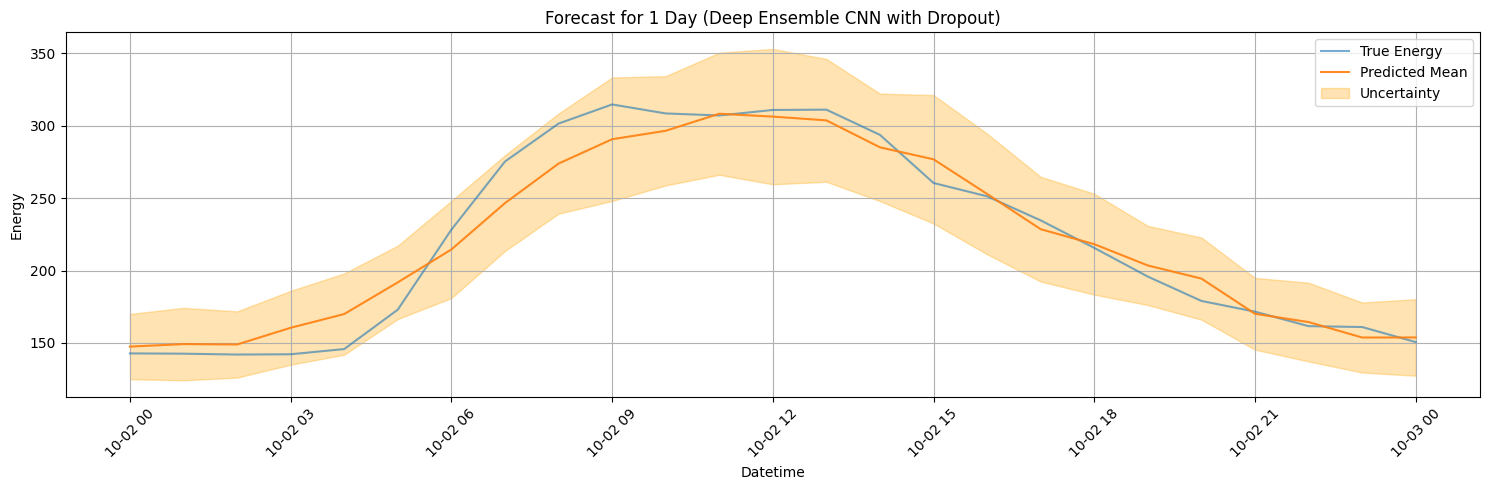

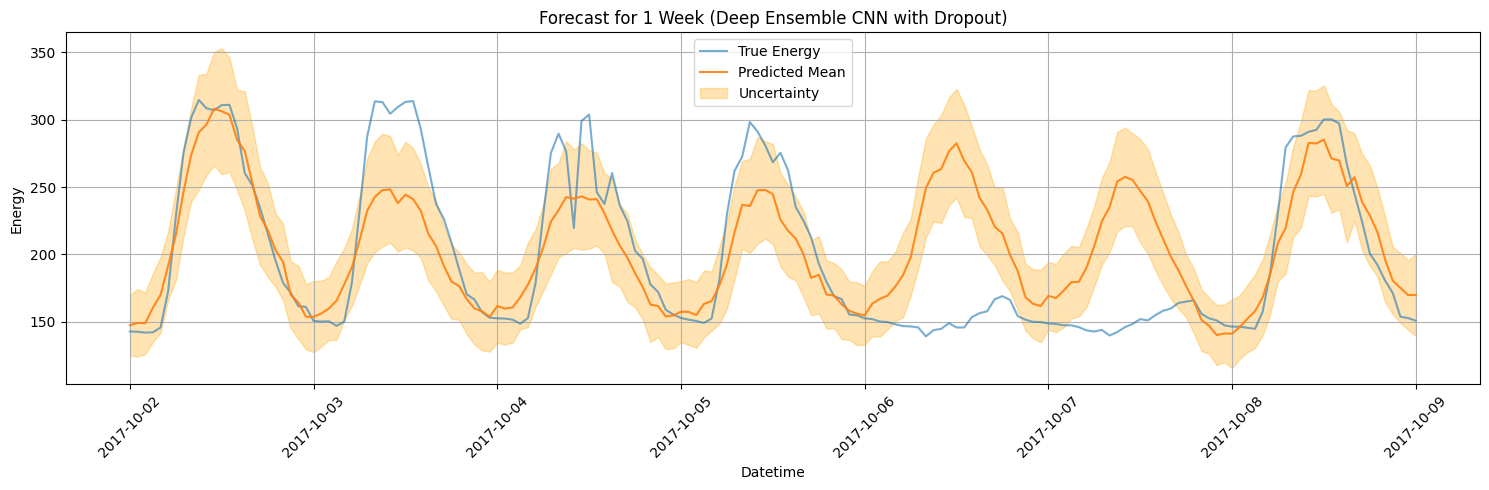

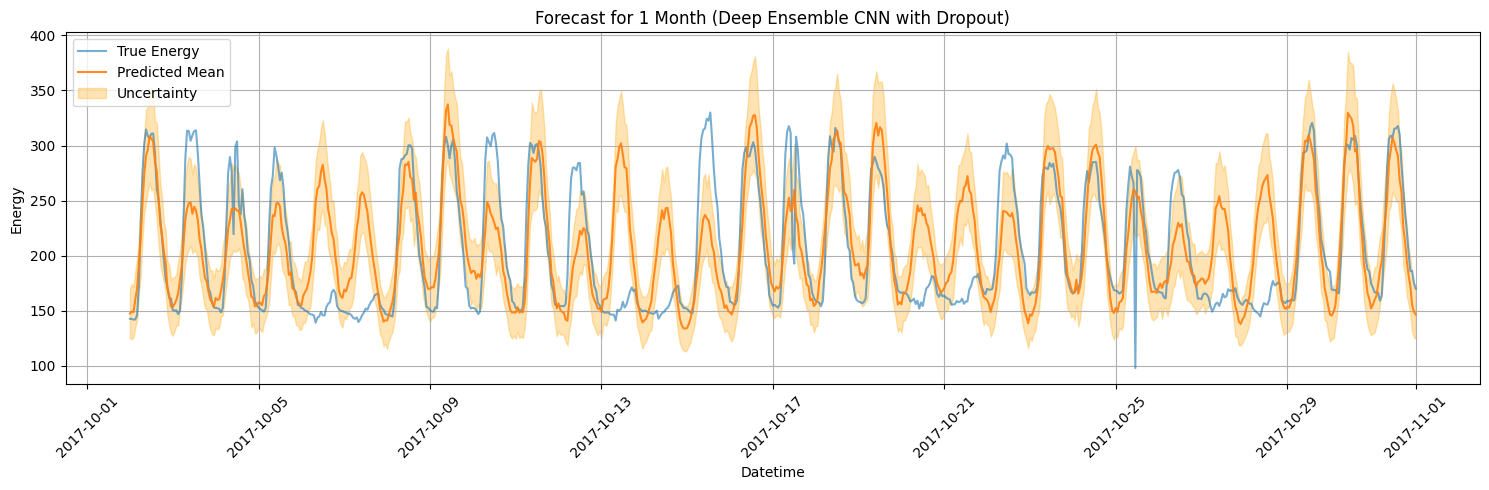

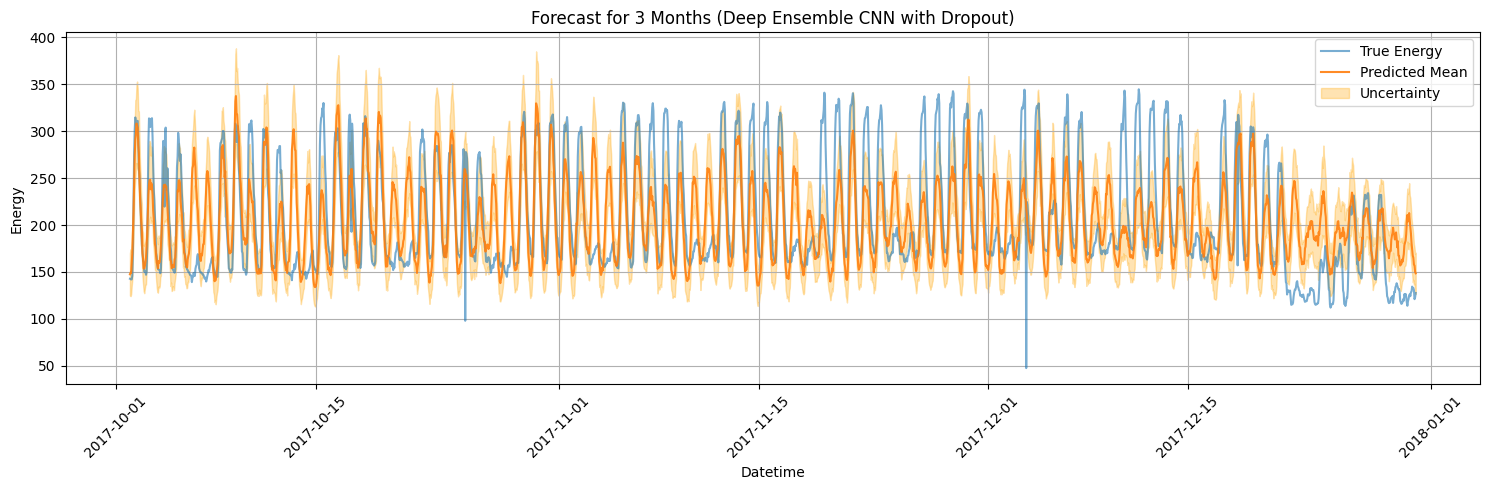

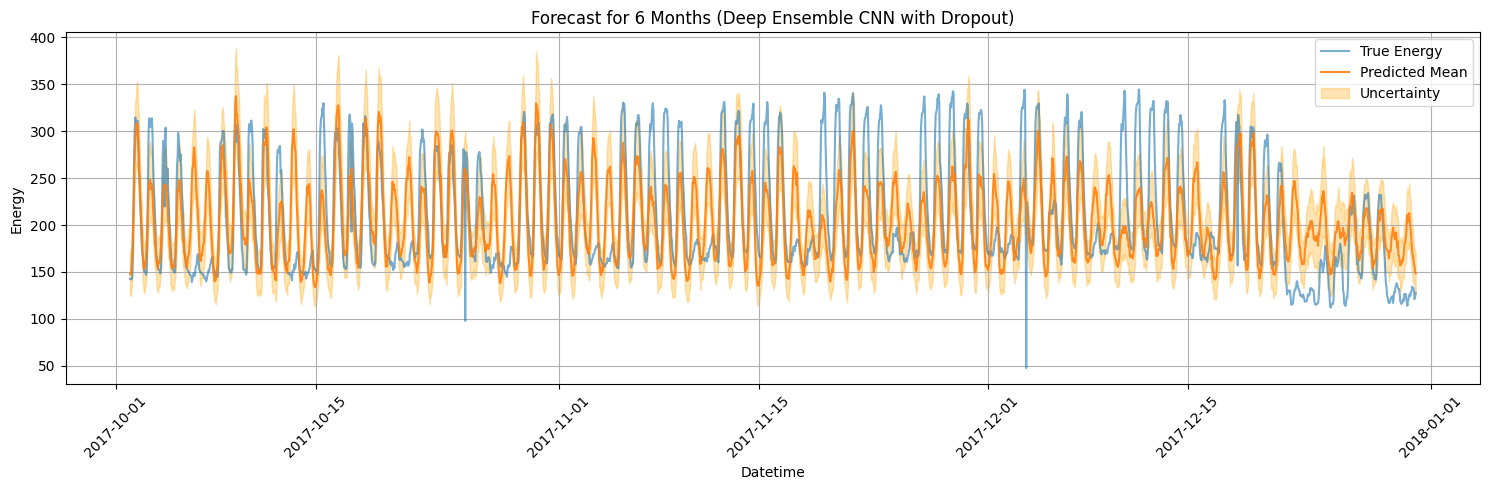

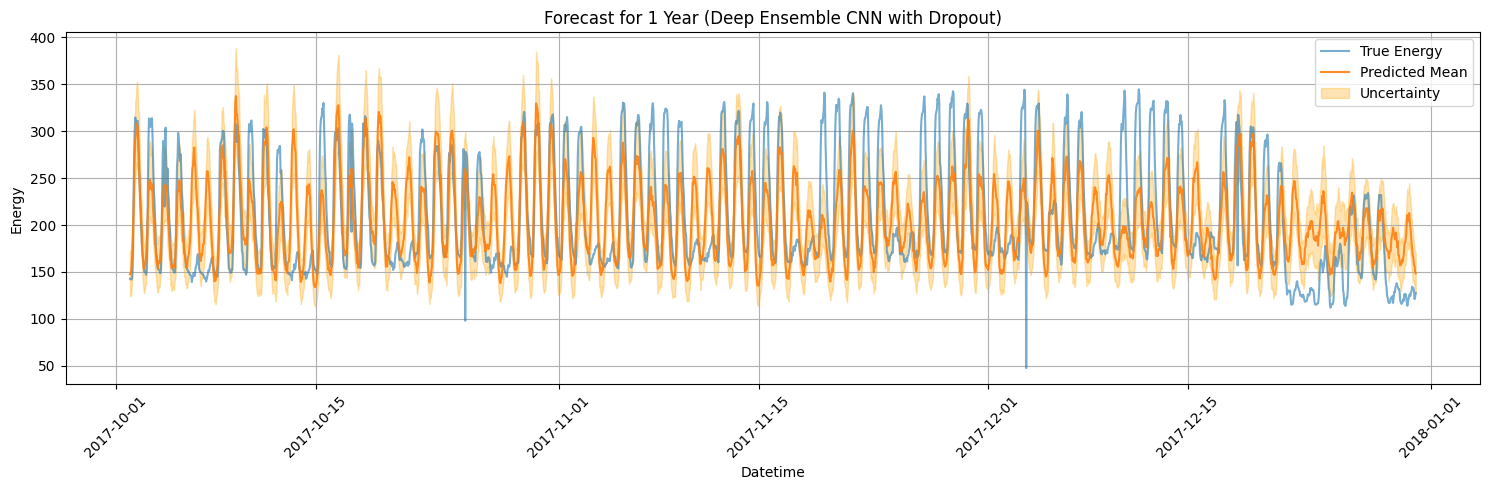

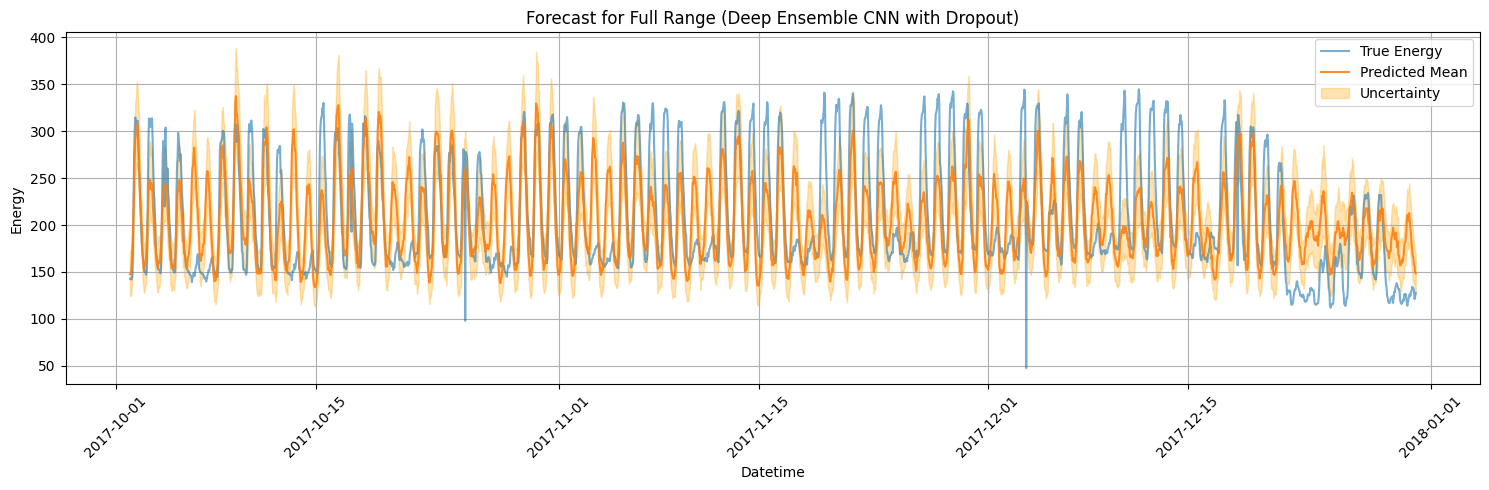

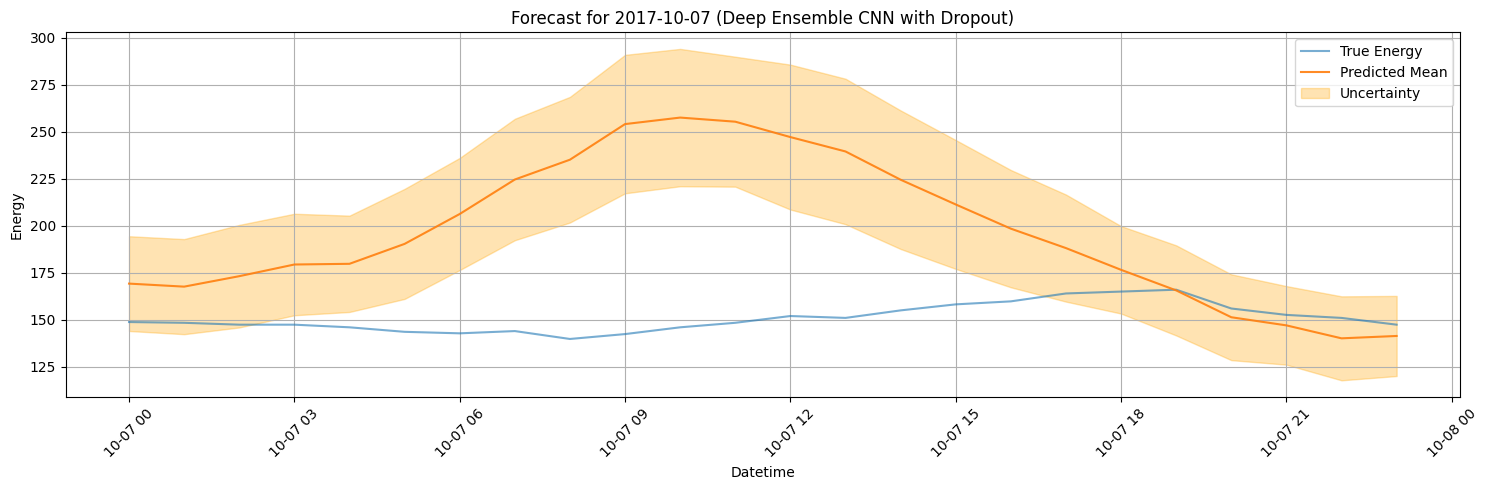

In [3]:
# --- Plot Forecasts Over Multiple Time Spans ---
from datetime import timedelta

# Define time spans
time_spans = {
    '1 Day': timedelta(days=1),
    '1 Week': timedelta(weeks=1),
    '1 Month': timedelta(days=30),
    '3 Months': timedelta(days=90),
    '6 Months': timedelta(days=180),
    '1 Year': timedelta(days=365),
    'Full Range': time_test.iloc[-1] - time_test.iloc[0]
}

# Loop over each time span
for label, delta in time_spans.items():
    start_time = time_test.iloc[0]
    end_time = start_time + delta

    mask = (time_test >= start_time) & (time_test <= end_time)
    if mask.sum() == 0:
        continue  # skip if no data in range

    time_range = time_test[mask]
    true_values = y_test[mask]
    mean_values = mean_pred[mask]
    std_values = std_pred[mask]

    plt.figure(figsize=(15, 5))
    plt.plot(time_range, true_values, label="True Energy", alpha=0.6)
    plt.plot(time_range, mean_values, label="Predicted Mean", alpha=0.9)
    plt.fill_between(time_range,
                     mean_values - std_values,
                     mean_values + std_values,
                     color='orange', alpha=0.3, label="Uncertainty")
    plt.title(f"Forecast for {label} (Deep Ensemble CNN with Dropout)")
    plt.xlabel("Datetime")
    plt.ylabel("Energy")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


import datetime

# --- Specify the target date manually ---
target_date = pd.to_datetime("2017-10-07").date()  # ← change this to your desired date

# --- Filter the time_test for that specific date ---
mask = time_test.dt.date == target_date
time_day = time_test[mask]
true_day = y_test[mask]
mean_day = mean_pred[mask]
std_day = std_pred[mask]

# --- Check if there is data for that date ---
if len(time_day) == 0:
    print(f"No data available for {target_date}")
else:
    # --- Plot ---
    plt.figure(figsize=(15, 5))
    plt.plot(time_day, true_day, label="True Energy", alpha=0.6)
    plt.plot(time_day, mean_day, label="Predicted Mean", alpha=0.9)
    plt.fill_between(time_day,
                     mean_day - std_day,
                     mean_day + std_day,
                     color='orange', alpha=0.3, label="Uncertainty")
    plt.title(f"Forecast for {target_date} (Deep Ensemble CNN with Dropout)")
    plt.xlabel("Datetime")
    plt.ylabel("Energy")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


### J.2.Second model that we have the droup out in the test and train data 

Epoch 1/30


c:\Users\arman\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 7220.7563 - mae: 61.4003 - val_loss: 2186.8672 - val_mae: 34.8069
Epoch 2/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2455.9341 - mae: 37.9099 - val_loss: 2210.4448 - val_mae: 34.1963
Epoch 3/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2061.9072 - mae: 34.7118 - val_loss: 1994.4677 - val_mae: 32.6711
Epoch 4/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1970.3971 - mae: 34.0506 - val_loss: 1631.2920 - val_mae: 28.1807
Epoch 5/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1791.6927 - mae: 32.2919 - val_loss: 1724.4692 - val_mae: 29.0005
Epoch 6/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1839.4854 - mae: 32.5634 - val_loss: 2277.3152 - val_mae: 34.7763
Epoch 7/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1785.6428 - mae: 32.5373 - val_loss: 1598.7214 - val_mae: 28.6310
Epoch 8/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1809.6122 - mae: 32.1534 - val_loss: 2100.4563 - val_mae: 32.0647
Epo

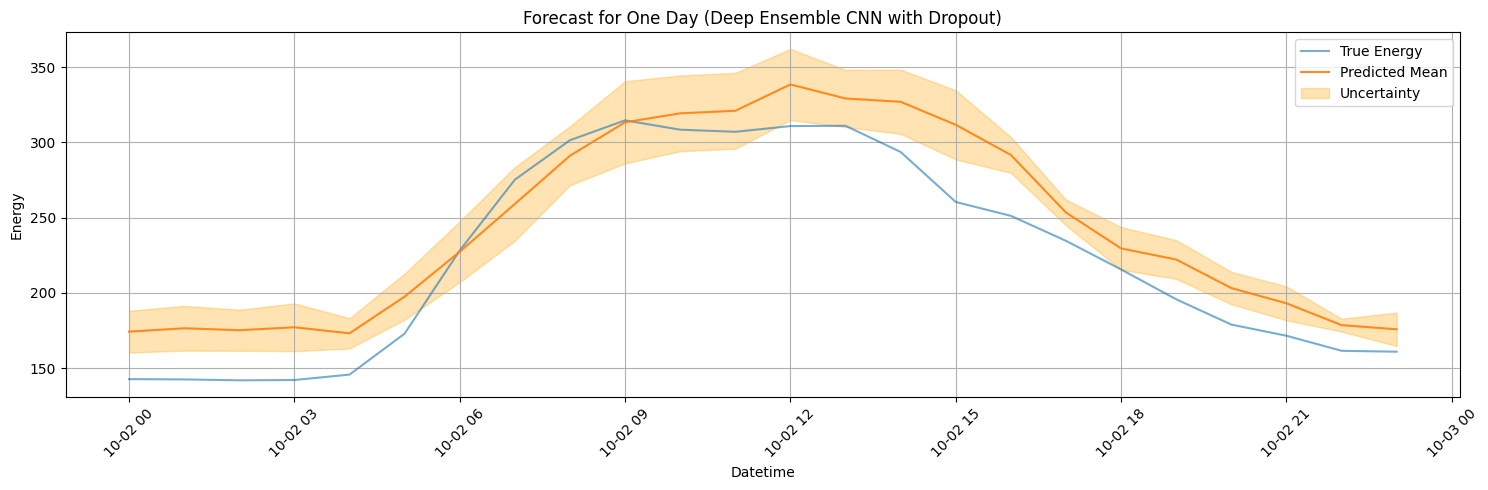

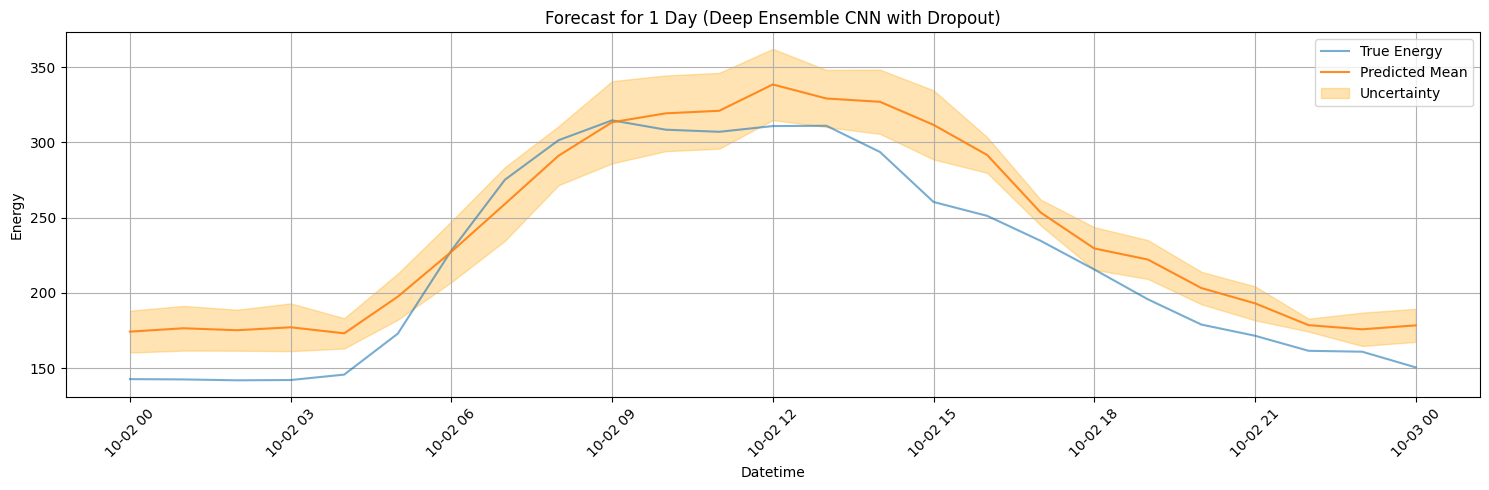

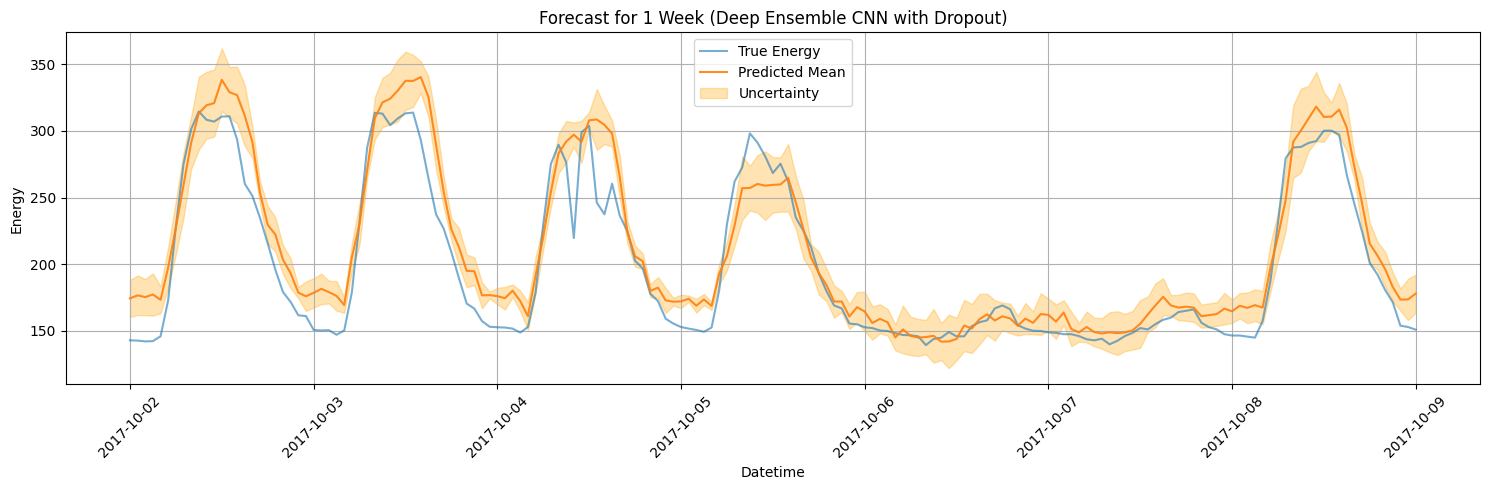

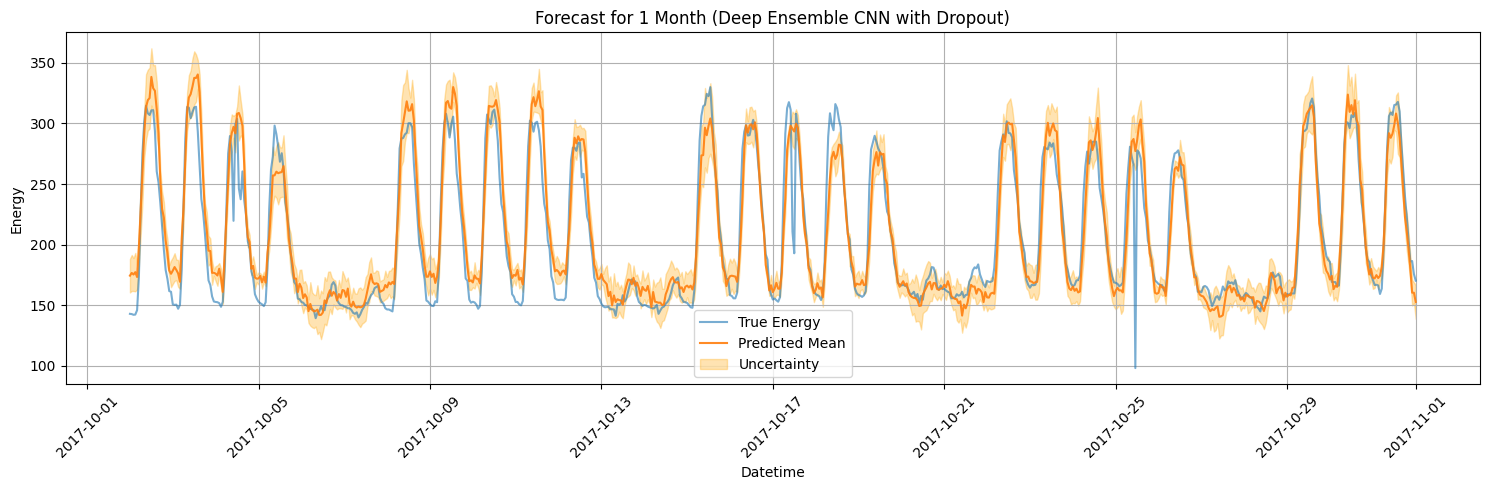

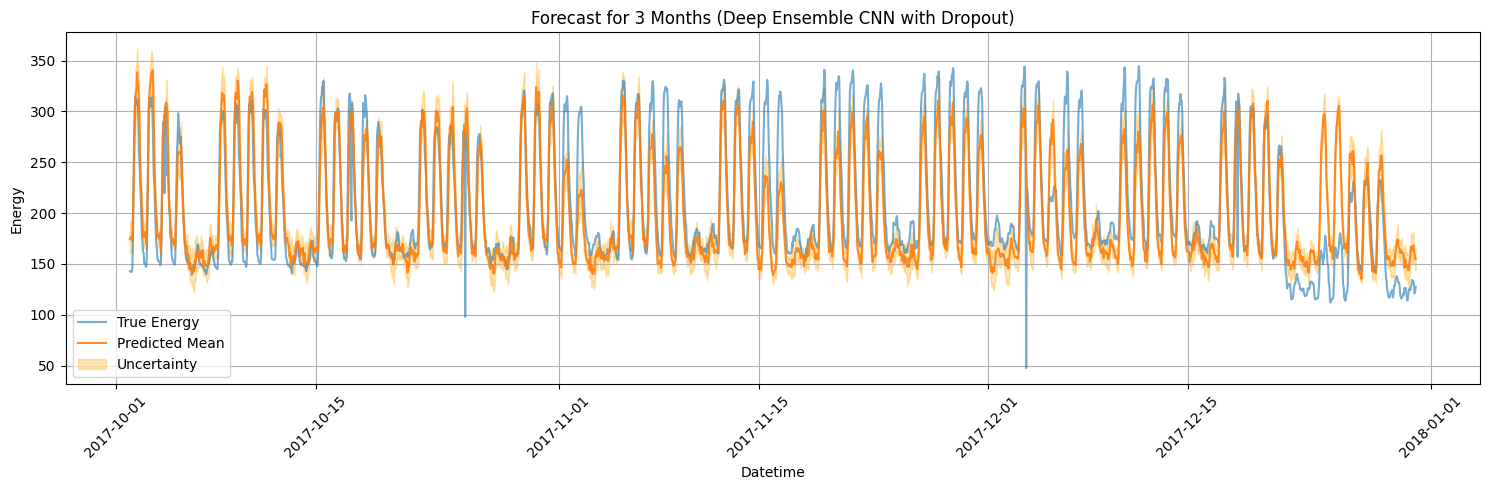

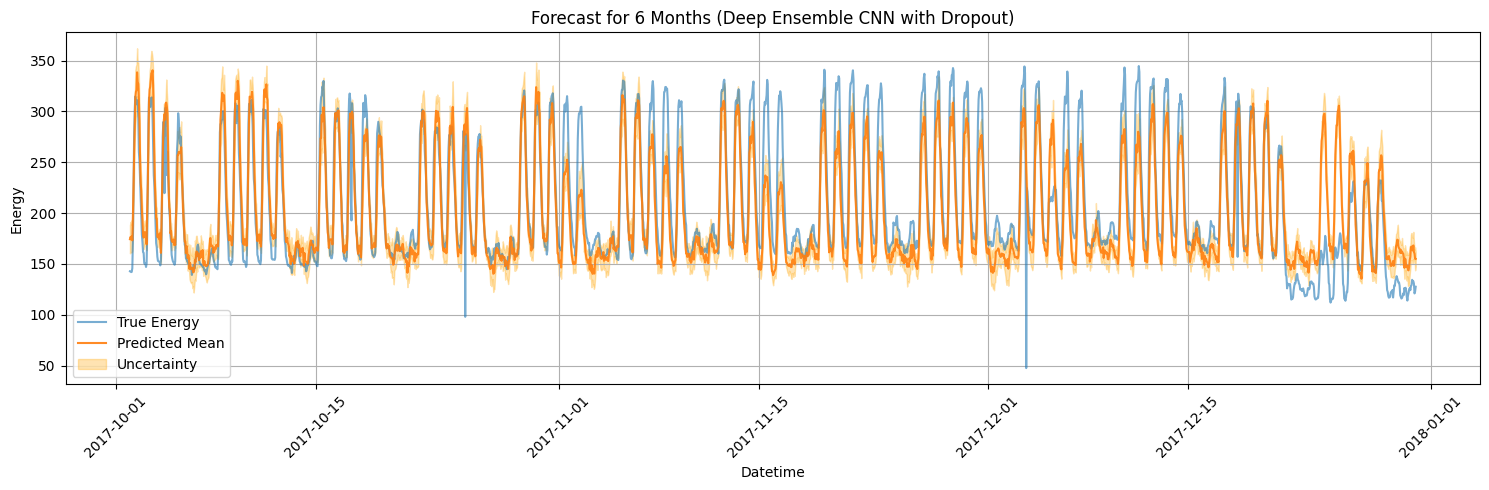

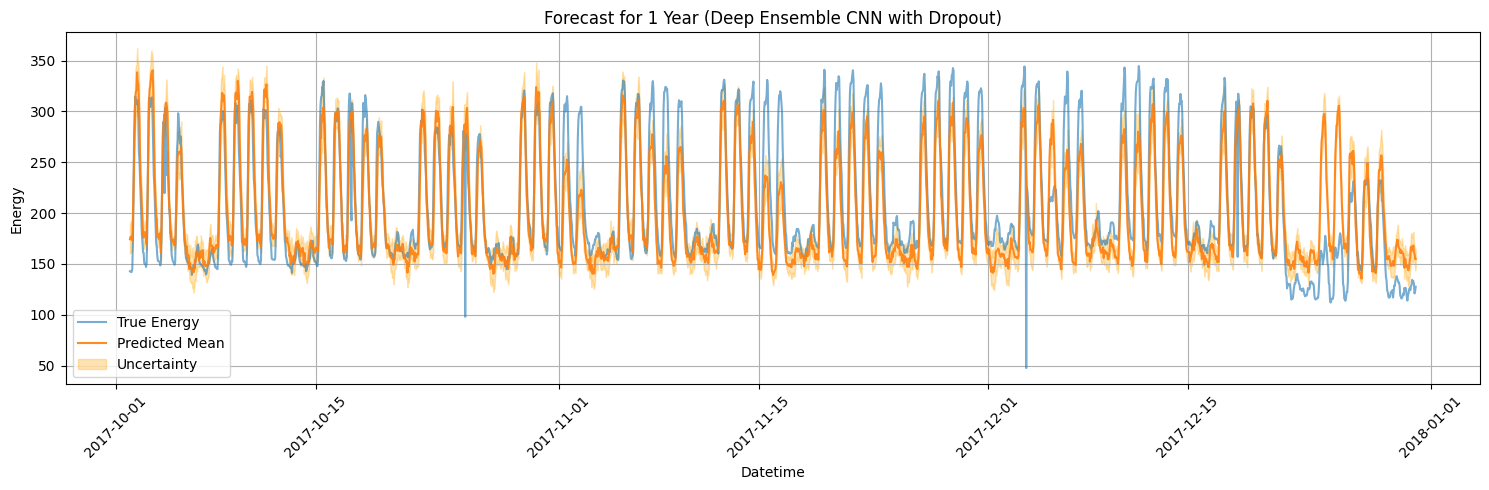

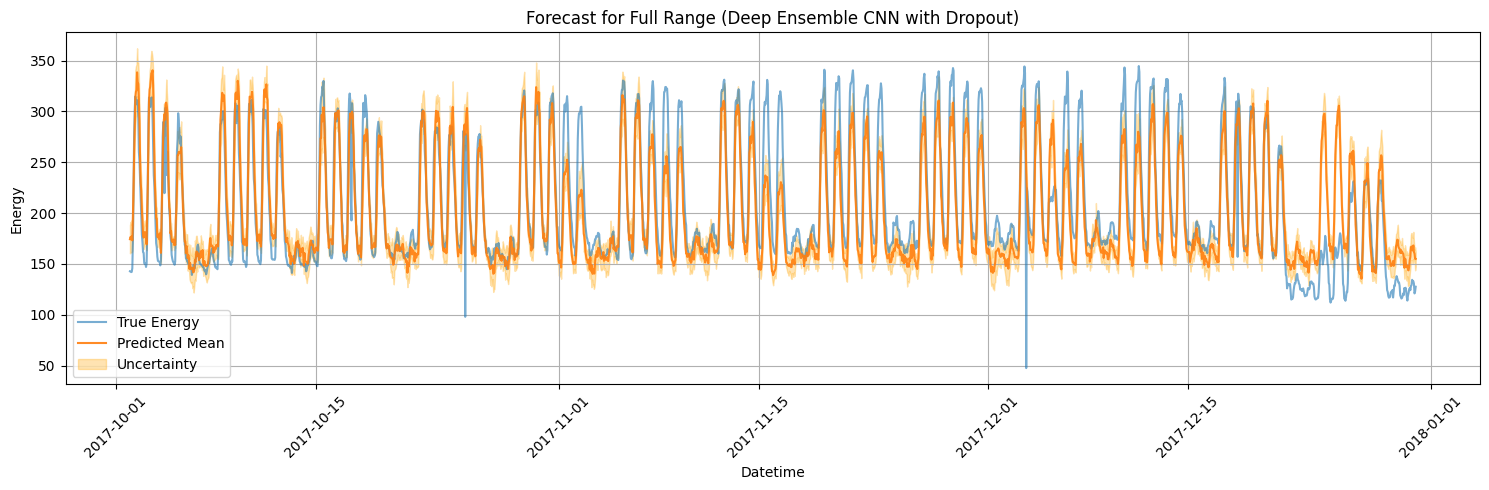

In [9]:
df_Train = pd.read_excel("X_train_scaled.xlsx")
df_Val = pd.read_excel("X_val_scaled.xlsx")
df_Test = pd.read_excel("X_test_scaled.xlsx")


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models
import matplotlib.dates as mdates

# --- Load holiday and weekend dataset ---
holidays_df = pd.read_excel("3.Holydays .xlsx")
holidays_df['DateKEY'] = pd.to_datetime(holidays_df['DateKEY'], format='%Y%m%d')  # Ensure the DateKEY column is datetime

# --- Prepare the weekend and holiday feature ---
def create_weekend_holiday_feature(df, holidays_df):
    # Convert 'datetime' column to datetime type
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Create 'is_weekend' feature (1 for weekend, 0 otherwise)
    df['is_weekend'] = df['datetime'].dt.weekday.isin([5, 6]).astype(int)  # 5=Saturday, 6=Sunday

    # Create 'is_holiday' feature (1 for holiday, 0 otherwise)
    df['is_holiday'] = df['datetime'].dt.date.isin(holidays_df['DateKEY'].dt.date).astype(int)

    return df

# --- Apply the function to all datasets (train, validation, test) ---
df_Train = create_weekend_holiday_feature(df_Train, holidays_df)
df_Val = create_weekend_holiday_feature(df_Val, holidays_df)
df_Test = create_weekend_holiday_feature(df_Test, holidays_df)

# --- Selected features including 'is_weekend' and 'is_holiday' ---
selected_features = [
    'air_temperature', 'diffuse_r', 'elspot', 'full_solar', 'global_r',
    'gust_speed', 'relative_humidity', 'sunshine', 'wind_speed', 'hour', 'weekday', 'is_weekend', 'is_holiday'
]

# --- Ensure 'hour' and 'weekday' are created ---
df_Train['hour'] = df_Train['datetime'].dt.hour
df_Train['weekday'] = df_Train['datetime'].dt.weekday
df_Val['hour'] = df_Val['datetime'].dt.hour
df_Val['weekday'] = df_Val['datetime'].dt.weekday
df_Test['hour'] = df_Test['datetime'].dt.hour
df_Test['weekday'] = df_Test['datetime'].dt.weekday

# --- Sliding Window Function with Weekend and Holiday Features ---
def create_sliding_windows_with_holiday(df, window_size, features, target):
    X, y, timestamps = [], [], []
    feature_array = df[features].values
    target_array = df[target].values
    datetime_array = pd.to_datetime(df['datetime'])

    for i in range(len(df) - window_size):
        X.append(feature_array[i:i + window_size])
        y.append(target_array[i + window_size])
        timestamps.append(datetime_array[i + window_size])

    return np.array(X), np.array(y), pd.Series(timestamps)

# --- Set the window size for sliding windows ---
window_size = 48  # 48 hours as an example, can be adjusted based on the data and needs

# --- Create sliding windows for all datasets ---
X_train, y_train, _ = create_sliding_windows_with_holiday(df_Train, window_size, selected_features, 'energy')
X_val, y_val, _ = create_sliding_windows_with_holiday(df_Val, window_size, selected_features, 'energy')
X_test, y_test, time_test = create_sliding_windows_with_holiday(df_Test, window_size, selected_features, 'energy')

# --- CNN Model with Dropout (for Uncertainty Estimation using MC Dropout) ---
def build_cnn_with_dropout():
    model = models.Sequential([
        layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(window_size, len(selected_features))),
        layers.Dropout(0.3),
        layers.Conv1D(64, kernel_size=3, activation='relu'),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(50, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# --- Train Ensemble of CNN Models ---
ensemble_models = []
n_ensemble = 5  # Number of models in the ensemble
epochs = 30

for _ in range(n_ensemble):
    model = build_cnn_with_dropout()
    model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_val, y_val), verbose=1)
    ensemble_models.append(model)

# --- Apply MC Dropout for Prediction with Uncertainty ---
def mc_dropout_predict(model, X, n_iter=20):
    predictions = np.array([model(X, training=True).numpy().flatten() for _ in range(n_iter)])
    return predictions.mean(axis=0), predictions.std(axis=0)

# --- Get Predictions and Uncertainty from Ensemble ---
predictions = np.array([mc_dropout_predict(model, X_test, n_iter=20)[0] for model in ensemble_models])
mean_pred = predictions.mean(axis=0)
std_pred = predictions.std(axis=0)

# --- Evaluation ---
mae = mean_absolute_error(y_test, mean_pred)
rmse = np.sqrt(mean_squared_error(y_test, mean_pred))
print(f"✅ MAE: {mae:.2f}")
print(f"✅ RMSE: {rmse:.2f}")

# --- Plot Forecast for 1 Day ---
day_indices = time_test.dt.date == time_test.iloc[0].date()  # Pick one day
time_day = time_test[day_indices]
true_day = y_test[day_indices]
mean_day = mean_pred[day_indices]
std_day = std_pred[day_indices]

plt.figure(figsize=(15, 5))
plt.plot(time_day, true_day, label="True Energy", alpha=0.6)
plt.plot(time_day, mean_day, label="Predicted Mean", alpha=0.9)
plt.fill_between(time_day, mean_day - std_day, mean_day + std_day, color='orange', alpha=0.3, label="Uncertainty")
plt.title("Forecast for One Day (Deep Ensemble CNN with Dropout)")
plt.xlabel("Datetime")
plt.ylabel("Energy")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot Forecasts Over Multiple Time Spans ---
from datetime import timedelta

# Define time spans
time_spans = {
    '1 Day': timedelta(days=1),
    '1 Week': timedelta(weeks=1),
    '1 Month': timedelta(days=30),
    '3 Months': timedelta(days=90),
    '6 Months': timedelta(days=180),
    '1 Year': timedelta(days=365),
    'Full Range': time_test.iloc[-1] - time_test.iloc[0]
}

# Loop over each time span and plot forecast
for label, delta in time_spans.items():
    start_time = time_test.iloc[0]
    end_time = start_time + delta

    mask = (time_test >= start_time) & (time_test <= end_time)
    if mask.sum() == 0:
        continue  # Skip if no data in range

    time_range = time_test[mask]
    true_values = y_test[mask]
    mean_values = mean_pred[mask]
    std_values = std_pred[mask]

    plt.figure(figsize=(15, 5))
    plt.plot(time_range, true_values, label="True Energy", alpha=0.6)
    plt.plot(time_range, mean_values, label="Predicted Mean", alpha=0.9)
    plt.fill_between(time_range,
                     mean_values - std_values,
                     mean_values + std_values,
                     color='orange', alpha=0.3, label="Uncertainty")
    plt.title(f"Forecast for {label} (Deep Ensemble CNN with Dropout)")
    plt.xlabel("Datetime")
    plt.ylabel("Energy")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
